In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_8297/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
import shutil

import numpy as np
import time
from pyDOE import lhs
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

In [3]:
import argparse
class Options_PoissonHD:
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--cuda', default=True, help='if you use cuda')
        
        parser.add_argument('--bot_top', type=tuple, default=(-1, 1), help='a tuple of the form (bot, top)')
        parser.add_argument('--dim', default=50, help='dimension')
        parser.add_argument('--N_r', default=8000, help='num of interior points')
        parser.add_argument('--N_b', default=4000, help='num of boundary points')
        
        parser.add_argument('--backbone_layers', type=list, default=([60]*5), help='list of nn layers of backbone')
        parser.add_argument('--backbone_lr', type=float, default=1e-3, help='initial learning rate of backbone')
        
        parser.add_argument('--gamma', type=float, default=0.95, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--step_size', type=int, default=1000, help='step_size of lr_scheduler for Adam optimizer')
        
        parser.add_argument('--iters_Adam', type=int, default=20000, help='iters for Adam')
        
        parser.add_argument('--lam_res', type=float, default=1, help='weight of loss_res')
        parser.add_argument('--lam_bcs', type=float, default=1, help='weight of loss_bcs')
        
        self.parser = parser

    def parse_default(self):
        args = self.parser.parse_args(args=[])
        args.device = torch.device('cuda' if args.cuda else 'cpu')
        
        # 增加网络输入输出层
        args.backbone_layers = [args.dim] + args.backbone_layers + [1]
        return args
    

args = Options_PoissonHD().parse_default()
print(args.cuda)

True


In [4]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth')
        shutil.copyfile(last_model, best_model)

def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [5]:
seed_torch(42)

## 网络模型 (Modified ResNet / ResNet / Modified MLP / MLP)

In [6]:
class ModifiedResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedResNet, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X = X + X_
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)

In [7]:
class ResNet(nn.Module):
    def __init__(self, mlp_layers):
        super(ResNet, self).__init__()
        
        self.model = nn.Sequential()
        
        first_layer = nn.Sequential()
        first_layer.add_module(f'fc0', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        first_layer.add_module(f'act0', nn.Tanh())
        self.model.add_module(f'first', first_layer)
        
        for i in range(1, len(mlp_layers)-2):
            block = nn.Sequential()
            block.add_module(f'fc{i}_0', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_0', nn.Tanh())
            block.add_module(f'fc{i}_1', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            block.add_module(f'act{i}_1', nn.Tanh())
            self.model.add_module(f'block{i}', block)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'last', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        X = self.model[0](X)
        for i_block in range(1, len(self.model) - 1):
            X_ = self.model[i_block](X)
            X = X_ + X
        return self.model[-1](X)

In [8]:
class ModifiedMLP(nn.Module):
    def __init__(self, mlp_layers):
        super(ModifiedMLP, self).__init__()
        
        self.encoder_u = nn.Sequential()
        self.encoder_u.add_module('fc_u', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_u.add_module('act_u', nn.Tanh())
        
        self.encoder_v = nn.Sequential()
        self.encoder_v.add_module('fc_v', nn.Linear(mlp_layers[0], mlp_layers[1], bias=True))
        self.encoder_v.add_module('act_v', nn.Tanh())
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        u = self.encoder_u(X)
        v = self.encoder_v(X)
        
        for i in range(len(self.model) - 1):
            X = self.model[i](X)
            X = X / 2.
            X = (1 - X) * u + X * v
        return self.model[-1](X)

In [9]:
class MLP(nn.Module):
    def __init__(self, mlp_layers):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            layer = nn.Sequential()
            layer.add_module(f'fc{i}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            layer.add_module(f'act{i}', nn.Tanh())
            self.model.add_module(f'layer{i}', layer)

        last_layer = nn.Sequential()
        last_layer.add_module(f'fc{len(mlp_layers)-2}', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        self.model.add_module(f'layer{len(mlp_layers)-2}', last_layer)
        
#         for param in self.parameters():
#             if len(param.shape) > 1:
#                 nn.init.kaiming_normal_(param)
    
    def forward(self, X):
        return self.model(X)


In [10]:
backbone = ResNet(args.backbone_layers)
backbone = backbone.to(args.device)
args.backbone = backbone
print(args.backbone)

ResNet(
  (model): Sequential(
    (first): Sequential(
      (fc0): Linear(in_features=50, out_features=60, bias=True)
      (act0): Tanh()
    )
    (block1): Sequential(
      (fc1_0): Linear(in_features=60, out_features=60, bias=True)
      (act1_0): Tanh()
      (fc1_1): Linear(in_features=60, out_features=60, bias=True)
      (act1_1): Tanh()
    )
    (block2): Sequential(
      (fc2_0): Linear(in_features=60, out_features=60, bias=True)
      (act2_0): Tanh()
      (fc2_1): Linear(in_features=60, out_features=60, bias=True)
      (act2_1): Tanh()
    )
    (block3): Sequential(
      (fc3_0): Linear(in_features=60, out_features=60, bias=True)
      (act3_0): Tanh()
      (fc3_1): Linear(in_features=60, out_features=60, bias=True)
      (act3_1): Tanh()
    )
    (block4): Sequential(
      (fc4_0): Linear(in_features=60, out_features=60, bias=True)
      (act4_0): Tanh()
      (fc4_1): Linear(in_features=60, out_features=60, bias=True)
      (act4_1): Tanh()
    )
    (last): S

## 数据集生成

In [11]:
class Dataset_PoissonHD:
    def __init__(self, bot_top, dim, device, N_max=100000):
        """
        bot_top: 空间的上下界 默认是(-1,1)
        N_max: 原始的总样本点数 例如interior(N_r) 从N_max中随机采样N_r个点作为初始点
        """
        self.bot, self.top = bot_top
        self.dim = dim
        self.device = device
        self.N_max = N_max
    
    def train_data(self, N_r, N_b):
        """训练点采样"""
        X_res = self.interior(N_r).to(self.device)
        X_bcs = self.boundary(N_b).to(self.device)
        f_res = self.func_res(X_res).to(self.device)
        u_bcs = self.func_bcs(X_bcs).to(self.device)
        
        return X_res, X_bcs, f_res, u_bcs
    
    def interior(self, N_r):
        """内部点采样"""
        X_res = torch.Tensor(self.N_max, self.dim).uniform_(self.bot, self.top)
        idx = torch.randperm(self.N_max)
        idx = idx[:N_r]
        return X_res[idx]
    
    def boundary(self, N_b):
        """边界点采样"""
        X_bcs = torch.Tensor(self.N_max, self.dim).uniform_(self.bot, self.top)
        bots = self.bot * torch.ones(1, 1)
        tops = self.top * torch.ones(1, 1)
        
        n = int(self.N_max / self.dim / 2)
        num = [n * i for i in range(2 * self.dim)]
        num[0] = 0
        num.append(self.N_max)
        
        for i in range(self.dim):  # 逐个维度设为下界bot 以及上界top 得到边界点
            X_bcs[num[2 * i]:num[2 * i + 1], i] = bots.repeat(num[2 * i + 1] - num[2 * i], 1).squeeze()
            X_bcs[num[2 * i + 1]:num[2 * i + 2], i] = tops.repeat(num[2 * i + 2] - num[2 * i + 1], 1).squeeze()

        idx = torch.randperm(self.N_max)
        idx = idx[:N_b]
        return X_bcs[idx]
    
    def func_res(self, X_res):
        """控制方程右端项"""
        f = X_res.mean(axis=1, keepdims=True)
        f = (torch.sin(f) - 2) / self.dim
        return f
    
    def func_bcs(self, X_bcs):
        """边界条件右端项"""
        u_bcs = X_bcs.mean(axis=1, keepdims=True)
        u_bcs = u_bcs ** 2 + torch.sin(u_bcs)
        return u_bcs


dataset = Dataset_PoissonHD(args.bot_top, args.dim, args.device)
args.dataset = dataset
X_res, X_bcs, f_res, u_bcs = dataset.train_data(args.N_r, args.N_b)
print(X_res.shape, X_bcs.shape, f_res.shape, u_bcs.shape)

torch.Size([8000, 50]) torch.Size([4000, 50]) torch.Size([8000, 1]) torch.Size([4000, 1])


## 训练

In [12]:
class Trainer_PoissonHD:
    def __init__(self, args):
        self.args = args
        self.dim = args.dim
        self.device = args.device
        
        self.N_r = args.N_r
        self.N_b = args.N_b
        self.dataset = args.dataset
        
        self.lam_res = args.lam_res
        self.lam_bcs = args.lam_bcs
        self.gamma = args.gamma
        self.backbone = args.backbone
        
        self.model_name = self.backbone.__class__.__name__
        self.model_path = self.get_model_path()
        
        self.iters_Adam = args.iters_Adam

        # eps = np.finfo(np.float32).eps
        self.optimizer_Adam = optim.Adam(self.backbone.parameters(), lr=args.backbone_lr, betas=(0.9, 0.999))
        
        self.step_size = args.step_size#int( self.iters_stage4 / (np.log(1e-3) / np.log(self.gamma)) )
        self.scheduler = ExponentialLR(self.optimizer_Adam, gamma=self.gamma, verbose=True)
        
        # data
        self.X_res, self.X_bcs, self.f_res, self.u_bcs = self.dataset.train_data(self.N_r, self.N_b)
        
        # Logger
        self.logger = {
            "loss": [],
            "loss_res": [],
            "loss_bcs": [],
            "iter": []
        }
        self.logger_valid = {
            "loss": [],
            "loss_res": [],
            "loss_bcs": [],
            "iter": [],
            "error": [],  # relative l2 error
        }
        
    def get_model_path(self):
        """生成保存模型的路径"""
        if not os.path.exists('models'):
            os.mkdir('models')
        
        path = os.path.join('models', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        
        return path
        
    def update_train_data(self):
        """更新采样点"""
        self.X_res, self.X_bcs, self.f_res, self.u_bcs = self.dataset.train_data(self.N_r, self.N_b)

    def net_u(self, X):
        return self.backbone(X)

    def net_r(self, x):
        x.requires_grad_(True)

        u = self.net_u(x)
        grad_u = grad(u, x)[0]
        u_xx = torch.zeros(u.shape).to(self.device)
        for i in range(self.dim):
            u_xx += grad(grad_u[:, [i]], x)[0][:, [i]]

        return - u_xx
    
    def compute_loss(self):
        """计算loss"""
        f_res_pred = self.net_r(self.X_res)
        self.loss_res = torch.mean((f_res_pred - self.f_res) ** 2)

        u_bcs_pred = self.net_u(self.X_bcs)
        self.loss_bcs = torch.mean((u_bcs_pred - self.u_bcs) ** 2)

        self.loss = self.lam_res * self.loss_res + self.lam_bcs * self.loss_bcs


    def log_loss(self):
        """记录当前loss至logger字典"""
        self.logger["loss"].append(self.loss.item())
        self.logger["loss_res"].append(self.loss_res.item())
        self.logger["loss_bcs"].append(self.loss_bcs.item())
        self.logger["iter"].append(self.iter + 1)

    def log_info(self):
        """保存并打印训练信息"""
        info = f'Iter {self.iter+1:5d} Time:{time.time()-self.start_time:.1e} # ' + \
               f'Loss:{self.loss.item():.2e}, Loss_r:{self.loss_res.item():.2e}, Loss_b:{self.loss_bcs.item():.2e} # ' + \
               f'Valid:{self.valid_loss_value:.2e}, RL2:{self.error_u:.2e}'
        with open("train_info.txt", 'a') as f:
            f.write(info + '\n')
        print(info)
        
    def compute_rl2(self, X_res):
        # 计算relative l2 error
        u_star = X_res.mean(axis=1, keepdims=True)
        u_star = u_star**2 + torch.sin(u_star)
        u_star = u_star.detach().cpu().numpy()
        
        u_pred = self.net_u(X_res)  # 计算预测解
        u_pred = u_pred.detach().cpu().numpy()
        
        error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)  # rl2 error
        return error_u

    def valid(self):
        """验证并保存最优模型"""
        # 计算loss
        X_res, X_bcs, f_res, u_bcs = self.dataset.train_data(1000, 1000)
        self.backbone.eval()
        # 不经过transformer的loss
        f_res_pred = self.net_r(X_res)
        u_bcs_pred = self.net_u(X_bcs)
        loss_res = torch.mean((f_res_pred - f_res) ** 2)
        loss_bcs = torch.mean((u_bcs_pred - u_bcs) ** 2)
        loss = self.lam_res * loss_res + self.lam_bcs * loss_bcs
        
        # 计算relative l2 error
        self.error_u = self.compute_rl2(X_res)
        
        self.backbone.train()
        
        # 记录valid的loss和rl2 error信息
        self.logger_valid["loss"].append(loss.item())
        self.logger_valid["loss_res"].append(loss_res.item())
        self.logger_valid["loss_bcs"].append(loss_bcs.item())
        self.logger_valid["iter"].append(self.iter + 1)
        self.logger_valid["error"].append(self.error_u)
        
        # 验证模型loss是否最优并选择保存
        self.valid_loss_value = loss.item()
        is_best = self.valid_loss_value < self.best_loss
        if is_best:
            self.best_loss = self.valid_loss_value
        state = {
            'iter': self.iter,
            'state_dict': self.backbone.state_dict(),
            'best_loss': self.best_loss
        }
        save_model(state, is_best, save_dir=self.model_path)
    
    def train(self):
        """训练"""
        self.start_time = time.time()
        self.best_loss = 1.e10
        
        self.iter = 0
        for _ in range(self.iters_Adam):
            self.optimizer_Adam.zero_grad()
            self.compute_loss()
            self.loss.backward()
            self.optimizer_Adam.step()
            self.log_loss()

            if (self.iter + 1) % 100 == 0:
                self.valid()
                self.log_info()
                self.update_train_data()

            if (self.iter + 1) % self.step_size == 0:
                self.scheduler.step()
            self.iter += 1
            
            
trainer = Trainer_PoissonHD(args)

Adjusting learning rate of group 0 to 1.0000e-03.


In [13]:
trainer.train()

Iter   100 Time:1.6e+01 # Loss:2.03e-04, Loss_r:1.13e-04, Loss_b:9.07e-05 # Valid:2.15e-04, RL2:1.18e-01
Iter   200 Time:3.3e+01 # Loss:1.32e-04, Loss_r:6.16e-05, Loss_b:7.03e-05 # Valid:1.61e-04, RL2:1.04e-01
Iter   300 Time:4.9e+01 # Loss:1.06e-04, Loss_r:4.37e-05, Loss_b:6.26e-05 # Valid:1.05e-04, RL2:9.70e-02
Iter   400 Time:6.6e+01 # Loss:9.49e-05, Loss_r:3.54e-05, Loss_b:5.95e-05 # Valid:1.13e-04, RL2:9.65e-02
Iter   500 Time:8.2e+01 # Loss:7.03e-05, Loss_r:2.86e-05, Loss_b:4.17e-05 # Valid:7.41e-05, RL2:7.50e-02
Iter   600 Time:9.9e+01 # Loss:5.21e-05, Loss_r:2.07e-05, Loss_b:3.14e-05 # Valid:5.95e-05, RL2:7.14e-02
Iter   700 Time:1.2e+02 # Loss:3.98e-05, Loss_r:1.60e-05, Loss_b:2.38e-05 # Valid:4.13e-05, RL2:5.90e-02
Iter   800 Time:1.3e+02 # Loss:2.64e-05, Loss_r:1.19e-05, Loss_b:1.46e-05 # Valid:2.56e-05, RL2:4.62e-02
Iter   900 Time:1.5e+02 # Loss:1.79e-05, Loss_r:9.35e-06, Loss_b:8.52e-06 # Valid:1.74e-05, RL2:3.70e-02
Iter  1000 Time:1.6e+02 # Loss:1.32e-05, Loss_r:7.64e-0

Iter  7600 Time:1.2e+03 # Loss:2.90e-06, Loss_r:1.82e-07, Loss_b:2.72e-06 # Valid:2.49e-06, RL2:1.75e-02
Iter  7700 Time:1.3e+03 # Loss:1.28e-06, Loss_r:2.13e-07, Loss_b:1.06e-06 # Valid:1.44e-06, RL2:1.35e-02
Iter  7800 Time:1.3e+03 # Loss:2.11e-07, Loss_r:1.45e-07, Loss_b:6.63e-08 # Valid:2.28e-07, RL2:3.25e-03
Iter  7900 Time:1.3e+03 # Loss:2.40e-06, Loss_r:6.28e-07, Loss_b:1.77e-06 # Valid:3.38e-06, RL2:1.80e-02
Iter  8000 Time:1.3e+03 # Loss:2.11e-07, Loss_r:1.45e-07, Loss_b:6.56e-08 # Valid:2.41e-07, RL2:3.21e-03
Adjusting learning rate of group 0 to 6.6342e-04.
Iter  8100 Time:1.3e+03 # Loss:2.12e-07, Loss_r:1.50e-07, Loss_b:6.13e-08 # Valid:2.46e-07, RL2:3.08e-03
Iter  8200 Time:1.3e+03 # Loss:6.20e-07, Loss_r:2.74e-07, Loss_b:3.46e-07 # Valid:5.20e-07, RL2:6.20e-03
Iter  8300 Time:1.4e+03 # Loss:1.97e-07, Loss_r:1.37e-07, Loss_b:5.99e-08 # Valid:2.56e-07, RL2:2.96e-03
Iter  8400 Time:1.4e+03 # Loss:1.86e-07, Loss_r:1.22e-07, Loss_b:6.34e-08 # Valid:1.74e-07, RL2:2.70e-03
Iter 

Iter 15100 Time:2.5e+03 # Loss:3.96e-08, Loss_r:3.33e-08, Loss_b:6.34e-09 # Valid:3.84e-08, RL2:9.75e-04
Iter 15200 Time:2.5e+03 # Loss:2.01e-07, Loss_r:6.46e-08, Loss_b:1.37e-07 # Valid:3.00e-07, RL2:5.57e-03
Iter 15300 Time:2.5e+03 # Loss:2.16e-08, Loss_r:1.64e-08, Loss_b:5.16e-09 # Valid:2.34e-08, RL2:8.45e-04
Iter 15400 Time:2.5e+03 # Loss:1.05e-07, Loss_r:2.92e-08, Loss_b:7.54e-08 # Valid:2.94e-07, RL2:5.90e-03
Iter 15500 Time:2.6e+03 # Loss:2.93e-08, Loss_r:2.45e-08, Loss_b:4.82e-09 # Valid:1.91e-08, RL2:8.65e-04
Iter 15600 Time:2.6e+03 # Loss:2.62e-07, Loss_r:4.25e-08, Loss_b:2.19e-07 # Valid:3.12e-07, RL2:5.68e-03
Iter 15700 Time:2.6e+03 # Loss:1.35e-07, Loss_r:4.00e-08, Loss_b:9.47e-08 # Valid:2.92e-07, RL2:6.00e-03
Iter 15800 Time:2.6e+03 # Loss:2.79e-08, Loss_r:1.88e-08, Loss_b:9.05e-09 # Valid:3.48e-08, RL2:1.23e-03
Iter 15900 Time:2.6e+03 # Loss:4.45e-08, Loss_r:3.81e-08, Loss_b:6.47e-09 # Valid:2.62e-08, RL2:1.08e-03
Iter 16000 Time:2.6e+03 # Loss:5.44e-08, Loss_r:1.47e-0

In [14]:
np.save("./loss_logger_dict.npy", trainer.logger)
np.save("./loss_logger_valid_dict.npy", trainer.logger_valid)

## 结果可视化

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})

### 训练的loss图

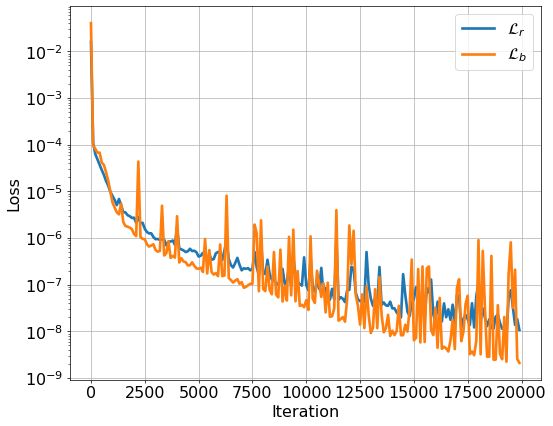

In [16]:
# loss图
loss_logger = np.load("./loss_logger_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 100
# ax.plot(loss_logger["iter"][::k], loss_logger["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_res"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
ax.plot(loss_logger["iter"][::k], loss_logger["loss_bcs"][::k], label=r"$\mathcal{L}_{b}$", linewidth=3)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Loss.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的loss图 (包括只经backbone和经过transformer和backbone的loss)

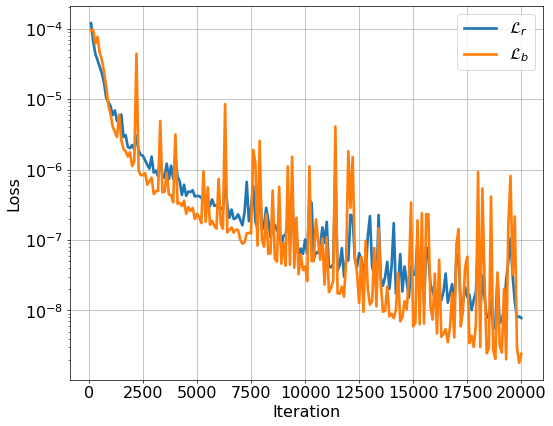

In [17]:
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 1
# ax.plot(loss_logger_valid["iter"][::k], loss_logger_valid["loss"][::k], label=r"$\mathcal{L}$", linewidth=3)
ax.plot(loss_logger_valid["iter"][::k], loss_logger_valid["loss_res"][::k], label=r"$\mathcal{L}_{r}$", linewidth=3)
ax.plot(loss_logger_valid["iter"][::k], loss_logger_valid["loss_bcs"][::k], label=r"$\mathcal{L}_{b}$", linewidth=3)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.grid()

ax.legend(loc='upper right')

plt.tight_layout()
# plt.savefig('loss_valid.png', dpi=100, bbox_inches='tight')
plt.show()

### 验证的Relative L2 error图 (包括只经backbone和经过transformer和backbone的rl2)

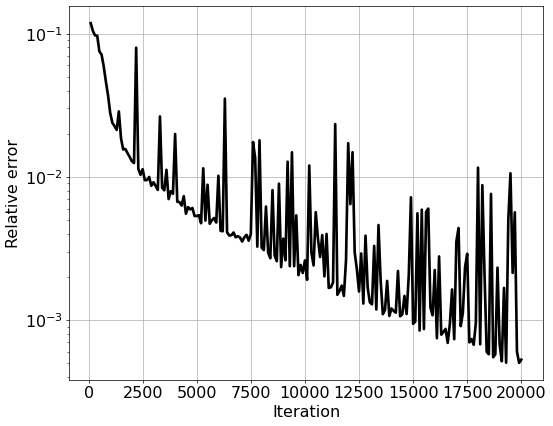

In [18]:
# valid中记录的relative l2 error记录 第一行只经过backbone 第二行经过transformer和backbone
loss_logger_valid = np.load("./loss_logger_valid_dict.npy", allow_pickle=True).item()

fig = plt.figure(figsize=(9, 7), dpi=64)
ax = fig.subplots()

k = 1
ax.plot(loss_logger_valid["iter"][::k], loss_logger_valid["error"][::k], label=r"PINN", color='k', linewidth=3)
ax.set_yscale('log')
ax.set_xlabel("Iteration")
ax.set_ylabel("Relative error")
ax.grid()

plt.tight_layout()
plt.savefig('Relative_L2_error.png', dpi=100, bbox_inches='tight')
plt.show()

### Relative L2 error (仅考虑内部点）

In [19]:
# 使用最好的模型
backbone = ResNet(args.backbone_layers)
state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
backbone.load_state_dict(state_dict['state_dict'])
backbone.eval()
print("Iter:\t", state_dict['iter'] + 1)
print("Loss:\t", "{:.2e}".format(state_dict['best_loss']))

Iter:	 18700
Loss:	 8.16e-09


In [20]:
def exact_sol(X):
    # 解析解
    u_star = X.mean(axis=1, keepdims=True)
    u_star = u_star**2 + np.sin(u_star)
    return u_star

# 采样内部点
dataset = Dataset_PoissonHD(args.bot_top, args.dim, torch.device('cpu'))
X_res, _, _, _ = dataset.train_data(N_r=10000, N_b=0)
# 计算u_star u_pred
u_star = exact_sol(X_res)
u_pred = backbone(X_res)

u_star = u_star.detach().numpy()
u_pred = u_pred.detach().numpy()
#计算L2相对误差
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
with open("RL2.txt", 'w') as f:
    f.write(str(error_u))
print('Relative L2 error: {:.3e}'.format(error_u))

Relative L2 error: 5.747e-04


### 可视化内部(x1, x2, 0, ..., 0)

In [21]:
n = 101
dim = args.dim
# 取前两维
x1 = np.linspace(-1, 1, n)
x2 = np.linspace(-1, 1, n)
x1, x2 = np.meshgrid(x1, x2)
# x3, ..., x50 = 0
x12 = np.zeros((n*n, dim))
x12[:, [0]] = x1.reshape(-1, 1)
x12[:, [1]] = x2.reshape(-1, 1)
x12 = torch.from_numpy(x12).float()
# 解析解和预测解
u12_star = exact_sol(x12)
u12_pred = backbone(x12)

u12_star = u12_star.detach().numpy()
u12_pred = u12_pred.detach().numpy()

u12_star = u12_star.reshape(x1.shape)
u12_pred = u12_pred.reshape(x1.shape)

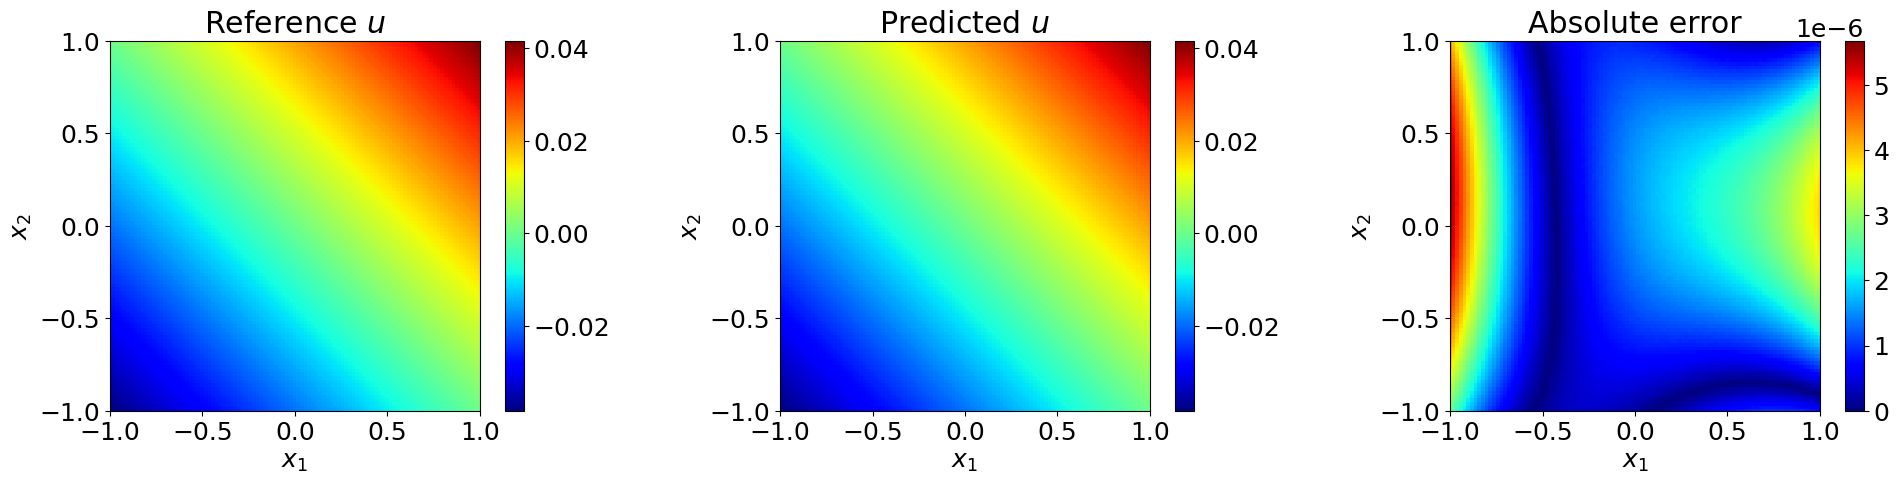

In [22]:
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(1, 3)

cax1 = axes[0].pcolor(x1, x2, u12_star, cmap='jet')
fig.colorbar(cax1)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_title(r'Reference $u$')
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-1, 1])
axes[0].set_xticks(np.arange(-1, 1.1, 0.5))
axes[0].set_yticks(np.arange(-1, 1.1, 0.5))
axes[0].set_aspect(1./axes[0].get_data_ratio())

cax2 = axes[1].pcolor(x1, x2, u12_pred, cmap='jet')
fig.colorbar(cax2)
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title(r'Predicted $u$')
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-1, 1])
axes[1].set_xticks(np.arange(-1, 1.1, 0.5))
axes[1].set_yticks(np.arange(-1, 1.1, 0.5))
axes[1].set_aspect(1./axes[1].get_data_ratio())

cax3 = axes[2].pcolor(x1, x2, np.abs(u12_star - u12_pred), cmap='jet')
fig.colorbar(cax3)
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].set_title('Absolute error')
axes[2].set_xlim([-1, 1])
axes[2].set_ylim([-1, 1])
axes[2].set_xticks(np.arange(-1, 1.1, 0.5))
axes[2].set_yticks(np.arange(-1, 1.1, 0.5))
axes[2].set_aspect(1./axes[2].get_data_ratio())

plt.tight_layout()
plt.savefig('HeatHD_result.png', dpi=100, bbox_inches='tight')
plt.show()

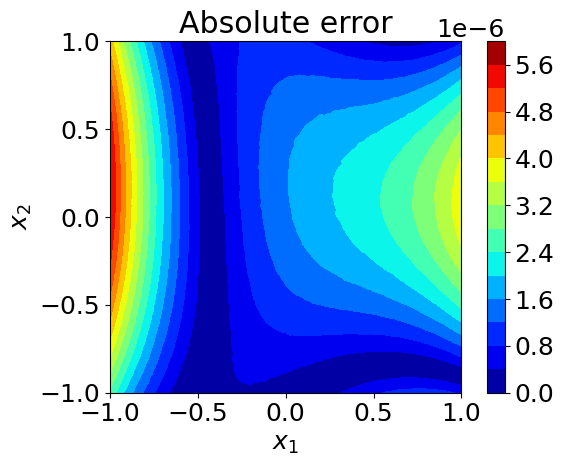

In [23]:
fig, ax = plt.subplots(figsize=(6.5, 5), dpi=100)
plot = ax.contourf(x1, x2, np.abs(u12_star - u12_pred), levels=16, cmap='jet')

cbar = fig.colorbar(plot)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_title('Absolute error')
ax.set_aspect(1./ax.get_data_ratio())
plt.tight_layout()
plt.savefig('./Absolute_error', dpi=100)
plt.show()